In [1]:
import numpy as np
import pydicom as dcm
import tensorflow as tf
import os
import random
import math

/home/minaessam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:

def get_data_set(paths_to_patients,train_ratio=1.0,test_ratio=0.0,valid_ratio=0.0\
                 ,check_validity=False,stage = "rest",choose=[],frames=[]):
    """
    takes list of paths to the whole directories containing the patients directories
      -dir1
          -patient1
          -patient2
          .....
    splits data into train,test and validation for the given ratios
    ratios not based on images rather based on patients
    if test ratio
    check_validity if true it will check the images in directory if they are labeled 
    if not it will skip the directory entirely
    
    """
    if type(paths_to_patients)!=list:
        paths_to_patients = [paths_to_patients]
    assert train_ratio+test_ratio+valid_ratio == 1.0 , "ratios must add up to 1.0 "
    
    patients = []
    train = []
    test = []
    validation = []
    
    for path in paths_to_patients:
        assert os.path.isdir(path) , "Expected directory to patients but given {}".format(path)
        
        for i in os.listdir(path):
            # add directories only
            i = os.path.join(path,i)
            if os.path.isdir(i):
                good_path = True
                if check_validity:
                    good_path = check_file_names(i)
                #insert only valid patients
                if good_path:
                    patients.append(i)
    train_split = int(math.ceil(train_ratio*len(patients)))
    test_split = int(math.ceil(test_ratio*len(patients)))
    valid_split = int(valid_ratio*len(patients))
    patients.sort()
    random.seed(100)
    random.shuffle(patients)
    train = patients[:train_split]
    test = patients[train_split:train_split+test_split]
    validation = patients[train_split+test_split:]
    
    return train,test,validation

def check_file_names(path_to_images):
    """
    checks if the whole directory contains labeled dicom images
    it prints if the containing folder labeled but without the whole classes
    it returns false if a single image isn't labeled but ignores all other files other than dicom
    """
    slices = {
    '3CH': '3ch', '3C': '3ch',
    '4CH': '4ch', '4C': '4ch',
    '2CH': '2ch', '2C': '2ch',
    'SA-B': 'basal', 'SAB': 'basal', 'BASAL': 'basal', 'BASE': 'basal', 'SLB': 'basal',
    'SA-M': 'mid', 'SAM': 'mid', 'MID': 'mid', 'SLM': 'mid',
    'SA-A': 'apical', 'SAA': 'apical', 'APICAL': 'apical', 'APEX': 'apical', 'SLA': 'apical'}
    # if not all classes found in the same directory show error
    found = {}
    for image in os.listdir(path_to_images):
        good = False
        if ".dcm" in image.lower():
            
            for key in slices.keys():
                if key in image:
                    good = True
                    found[key] = True
                    break
        else :
            # if not dicom image skip that's ok
            good = True
        if good == False:
            return good
    # for debugging show which one isn't full with all classes
    if len(found.keys()) != 6:
        if( len(found.keys())==0 ):
            # not .dcm and not labeled
            return False
        print("Warnning at ",path_to_images,"  found classes ",len(found.keys()))
        print(found.keys(),sep='\n')
        
    # the directory is okay
    return True
def dist(positions):
    arr = np.array(positions)
    return np.sqrt(np.sum(arr**2))

def read_data(paths_to_data,stages = "rest",choose=[],frames=[]):
    """
    extract dicom data from a given path/s (to patient/s)
    stage : selects the given stage/s 
    choose : select the given slice/s if empty it selects all
    frames : selects given time frame/s if empty selects all
    returns normalized examples
    """
    slices = {
    '3CH': '3ch', '3C': '3ch',
    '4CH': '4ch', '4C': '4ch',
    '2CH': '2ch', '2C': '2ch',
    'SA-B': 'basal', 'SAB': 'basal', 'BASAL': 'basal', 'BASE': 'basal', 'SLB': 'basal',
    'SA-M': 'mid', 'SAM': 'mid', 'MID': 'mid', 'SLM': 'mid',
    'SA-A': 'apical', 'SAA': 'apical', 'APICAL': 'apical', 'APEX': 'apical', 'SLA': 'apical'}
    #if choose empty choose all
    choose_key=[]
    if len(choose) == 0:
        choose_key = list(slices.keys())
        choose = list(set(slices.values()))
    else:
        for i in slices.keys():
            if slices[i] in choose:
                choose_key.append(i)
    #print(choose)
    examples = []
    labels = []
    if type(paths_to_data) != list:
        paths_to_data = [paths_to_data]
        
    if type(frames) != list:
        frames = [frames]
    if len(frames) == 0:
        #chooses every thing
        frames=['.']
    if type(stages)!= list:
        stages = [stages]
    visited = {}
    #construct a key for every stage,frame pair
    #but first construct the value 
    # a key value pair for slice and boolean
    #visited[stage,frame] = [('2ch',False),----] 
    #len(visited[stage,frame]) = len(choose)
    
    file = open('bad_images.txt','w')
    
    def check(iterable,name,sensitivity= False):
        for i in iterable:
            #if case insensitive make lower
            if not sensitivity:
                name = name.lower()
            if i in name:
                #print(i,name)
                return (True,i)
        return False,None
        
    for path in paths_to_data:
        
        #value = {sli:False for sli in choose}
        #construct the keys
        for stage in stages:
            for frame in frames:

                visited[stage+'/'+frame] = {sli:False for sli in choose}
        #don't refuse the whole patient because some error in some time frame , 
        #instead refuse this timeframe/stage combination
        examples_to_be_normalized = {key:[] for key in visited.keys()}
        per_patient_label = {key:[] for key in visited.keys()}
        for index,image_name in enumerate(os.listdir(path)):
            
            if ".dcm" in image_name.lower()  :
                
                #check stage
                skip,stage =  check(stages,image_name)
                skip = not skip
                if skip:
                    continue
                 
                #time frame search first
                skip,frame =  check(frames,image_name)
                skip = not skip
                if skip :
                    continue
                
                #check the choice
                skip,key =  check(choose_key,image_name,sensitivity=True)
                skip = not skip
                if skip:
                    continue               
                
                #check visited things
                if visited[stage+'/'+frame][slices[key]] == False:
                    #update when the image is read
                    
                    skip = False
                else :
                    skip = True
                            
                if skip:
                    continue
                
                
                
                     
                     
                try:
                    
                    dicom = dcm.read_file(os.path.join(path,image_name),force=True)
                    #print(index)
                    example = [*dicom.ImageOrientationPatient[0:3]\
                               ,*dicom.ImagePositionPatient\
                               ,dist(dicom.ImagePositionPatient)\
                                     ,dicom.SliceLocation]
                    label = '' 
                    for key in slices.keys():
                        if key in image_name:
                            label = slices[key]
                            if frames[0] != '.':
                                #select every thing if frames[0] == '.' by not marking them
                                visited[stage+'/'+frame][slices[key]] = True
                    if label == '':
                        print("label empty ",image_name)
                        return [],[]
                    examples_to_be_normalized[stage+'/'+frame].append(example)
                    per_patient_label[stage+'/'+frame].append(label)
                    
                except OSError :
                    print(" OSError exception found at ",os.path.join(path,image_name))
                #print(image_name)
        
#         #skip empty examples and non matching choices with data
#         if len(examples_to_be_normalized)==0:
#             print("not enough data for given stage,timeframe combination  0 found")
#             continue
#         elif len(examples_to_be_normalized)<len(choose)*len(frames):
#             print("not enough data for given stage,timeframe combination  ",len(examples_to_be_normalized)," found")
#             print(path)
#             continue
        for key in per_patient_label.keys():
            # in case of select all the total number will be > choose 
            #but in normal cases it should be equal
            if (len(per_patient_label[key]) == len(examples_to_be_normalized[key])) and\
                                                  (len(examples_to_be_normalized[key]) >= len(choose)):
                examples.append(normalize(examples_to_be_normalized[key]))
                labels.append(per_patient_label[key])
            else:
                #print("not added ",len(per_patient_label[key]),len(choose),len(examples_to_be_normalized[key]))
                file.write(path+"\n"+"found images for\t"+key+"\t"+str(len(per_patient_label[key]))+"\tnedded images\t"+str(len(choose))+"\t"+\
                           str(len(examples_to_be_normalized[key]))+"\n")
        #print(visited)
    file.close()
    assert len(examples)== len(labels), "non matching examples with labels  %d , %d"%(len(examples) , len(labels))
    
    return(np.array(examples),np.array(labels))
                
def normalize(examples):
    """
    returns normalized positions examples[i][3:6]
        normalize distances examples[i][6:8]
    """
    examples = np.array(examples)
    #print(examples.shape)
    
    pos_mean = np.mean(examples[:,3:6],axis=0)
    
    pos_std = np.std(examples[:,3:6],axis=0)
    #print(pos_mean,pos_std)
    #print(examples [:,3:6])
    examples [:,3:6] = (examples[:,3:6]- pos_mean)
    #print(examples [:,3:6])
    examples [:,3:6] = examples [:,3:6] /pos_std
    #print(examples [:,3:6])
    dis_mean = np.mean(examples[:,6:],axis=0)
    dis_std = np.std(examples[:,6:],axis=0)
    examples[:,6:] = (examples[:,6:]-dis_mean)/dis_std
    #print(examples[0,:]==examples[1,:])
    return examples[:,:]

In [15]:
paths = ['/home/minaessam/Documents/dicom_test/datasets_annotated_by_marina/',\
         '/home/minaessam/Documents/dicom_test/datasets-annotated by-mayar']

train_x,test_x,valid_x= get_data_set(paths,train_ratio=0.8,test_ratio=0.2,valid_ratio=0,check_validity=True)


In [16]:
print(len(train_x),len(test_x),len(valid_x))

49 12 0


In [17]:
x1=[os.path.basename(f) for f in train_x]
x2= [os.path.basename(f) for f in test_x]

for i in x1:
    if i in x2:
        print(i)

In [18]:
dire = os.path.join(paths[0],os.listdir(paths[0])[-4])
print(dire)
examples,labels=read_data(train_x,stages = ["rest","_d20","_d10"],frames=["01.","02.","03.","05."])
print(examples.shape, labels.shape)


/home/minaessam/Documents/dicom_test/datasets_annotated_by_marina/3032_exam_mf_2018_3_1_18_00


Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3fa
Expected sequence item with tag (fffe, e000) at file position 0x3f6
Expected sequence item with tag (fffe, e000) at 

 OSError exception found at  /home/minaessam/Documents/dicom_test/datasets-annotated by-mayar/patient2_exam_mm_2018_03_14/Patient2_REST_3SLM_01.dcm__2c675e3c-8a58-4337-9c49-a12d2148411b
 OSError exception found at  /home/minaessam/Documents/dicom_test/datasets-annotated by-mayar/patient2_exam_mm_2018_03_14/Patient2_REST_3CH__03.dcm__f82f0f29-3783-4d49-8bb4-8cb1ce40b101
 OSError exception found at  /home/minaessam/Documents/dicom_test/datasets-annotated by-mayar/patient2_exam_mm_2018_03_14/Patient2_REST_2CH__02.dcm__647b7c86-d083-4bc4-b3d3-340ef27ce436
 OSError exception found at  /home/minaessam/Documents/dicom_test/datasets-annotated by-mayar/patient2_exam_mm_2018_03_14/Patient2_REST_3SLA_05.dcm__5c08911b-9657-4397-a3e6-c203eff38252
 OSError exception found at  /home/minaessam/Documents/dicom_test/datasets-annotated by-mayar/patient2_exam_mm_2018_03_14/Patient2_REST_3SLA_02.dcm__f37fb064-89c6-41d5-b1d0-1677bce6d437
 OSError exception found at  /home/minaessam/Documents/dicom_test/data

In [19]:
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [20]:
def one_hot(labels):
    
    """
    takes labels in the form [2ch,3ch,...] and returns their corresponding one hot encoding
    """
    orderd_set = sorted(set(labels))
   
    dic = {key:i for i,key in enumerate(orderd_set)}
    out = np.zeros(shape=(len(labels),len(orderd_set)))
    for i,label in enumerate(labels):
        
        out[i,dic[label]]=1
    return out
    
colors = {'2ch':'green',
         '3ch':'blue',
         '4ch':'red',
         'apical':'black',
         'basal':'magenta',
         'mid':'yellow'}
x_train = np.reshape(examples,[-1,8])
y_train = np.reshape(labels,[-1])
outputs=6

y_train_one_hot = one_hot(y_train)
print(x_train.shape,y_train.shape,y_train_one_hot.shape)
print(y_train[0:8],y_train_one_hot[0:8],sep='\n')
# fig = plt.figure()

# ax = fig.gca(projection='3d')
# ax.view_init(elev=15., azim=45)
# base = 0
# for i in range (x_train.shape[0]):
#     ax.scatter3D(x_train[i,base],x_train[i,base+1] ,x_train[i,base+2], c=colors[y_train[i]])

(1440, 8) (1440,) (1440, 6)
['3ch' '4ch' 'apical' '2ch' 'basal' 'mid' 'mid' '4ch']
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


In [21]:
examples,labels=read_data(test_x,stages = ["rest","_d20","_d10"],frames=["01.","02.","03.","05."])
print(examples.shape)
x_test = np.reshape(examples,[-1,8])
y_test = np.reshape(labels,[-1])
y_test_one_hot = one_hot(y_test)
print(x_test.shape,y_test.shape,y_test_one_hot.shape)
print(y_test[:3],y_test_one_hot[:3])
# fig = plt.figure()

# ax = fig.gca(projection='3d')
# ax.view_init(elev=15., azim=45)
# base = 0
# for i in range (x_test.shape[0]):
#     ax.scatter3D(x_test[i,base],x_test[i,base+1] ,x_test[i,base+2], c=colors[y_test[i]])

(48, 6, 8)
(288, 8) (288,) (288, 6)
['3ch' '4ch' '2ch'] [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [12]:
units=8
outputs=6
seed = 10
layers = 3
initiz='xavier'
lr = .08

# model
tf.reset_default_graph()
with tf.get_default_graph().as_default() :
    input_x = tf.placeholder(shape=[None,x_train.shape[1]],dtype=tf.float64,name="input_x")
    input_y = tf.placeholder(shape=[None,outputs],dtype=tf.int32,name="input_y")

    hidden1 = tf.layers.dense(inputs=input_x,units=units,activation=tf.nn.sigmoid,name='hidden1'\
                              ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
    hidden2 = tf.layers.dense(inputs=hidden1,units=units,activation=tf.nn.sigmoid,name='hidden2'\
                              ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
    hidden3 = tf.layers.dense(inputs=hidden2,units=units,activation=tf.nn.sigmoid,name='hidden3'\
                             ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
    # hidden4 = tf.layers.dense(inputs=hidden3,units=units,activation=tf.nn.sigmoid,name='hidden4'\
    #                          ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))

    logits = tf.layers.dense(inputs=hidden3,units=outputs,name='logits')
    probs = tf.nn.softmax(logits=logits,name='softmax')
    classes = tf.argmax(probs,axis=1)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=input_y,name='cross_entropy_loss'))
    correct_pred = tf.equal(classes,tf.argmax(input_y,axis=1),name="correct_pred")
    accuracy = tf.reduce_mean(tf.cast(correct_pred,dtype=tf.float32),name="accuracy")
    step = tf.train.AdamOptimizer(lr).minimize(loss)

    acc_summ = tf.summary.scalar(name='training_accuracy',tensor=accuracy)
    loss_summ = tf.summary.scalar(name='loss',tensor=loss)
    summaries = tf.summary.merge_all()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [22]:
from sklearn.metrics import accuracy_score
model_name = 'model8units'

epochs = 200

sess = tf.Session(graph=tf.get_default_graph())
tf.set_random_seed(100)
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('summaries_'+model_name+str(layers),graph=sess.graph)
losses = []

for i in range(epochs):
    
    _,epoch_loss,summary = sess.run([step,loss,summaries],feed_dict={input_x:x_train,input_y:y_train_one_hot})
    writer.add_summary(summary,i)
    print(epoch_loss)
    losses.append(loss)
train_acc = accuracy_score(np.argmax(y_train_one_hot,axis=1),sess.run(classes,{input_x:x_train}))
test_acc =  accuracy_score(np.argmax(y_test_one_hot,axis=1),sess.run(classes,{input_x:x_test}))
print(np.argmax(y_test_one_hot,axis=1)[:15],sess.run(classes,{input_x:x_test})[:15],y_test[:15],sep='\n')
print(train_acc,test_acc)
saver = tf.train.Saver()
saver.save(sess,save_path='./'+model_name+str(layers))
with open(model_name+str(layers)+'.txt','w' )as f:
    
    f.write("layers\t"+str(layers)+"\n")
    f.write("units\t"+str(units)+"\n")
    f.write("seed\t"+str(seed)+"\n")
    f.write("initializer\t"+initiz+"\n")
    f.write("epochs\t"+str(epochs)+"\n")
    f.write("classes\t"+str(outputs))
    f.write("learning_rate\t"+str(lr))
    f.write("train_accuracy\t"+str(train_acc)+"\n")
    f.write("test_accuracy\t"+str(test_acc)+"\n")

1.8149474024304835
1.832864345603151
1.804577159525655
1.793601982470255
1.7946800126308764
1.786982903892919
1.7759218592998922
1.7674012533964918
1.7593347040889507
1.7468319578725526
1.726455604390896
1.6972827136627708
1.6595491993281435
1.6126539027008815
1.5546570028231605
1.484442487586563
1.4046581172531658
1.3221863180238238
1.2453780951698745
1.1795891342017748
1.1243639599171
1.0761348072510595
1.0326006776080865
0.9925324534003449
0.9547782489887621
0.91840761316706
0.8826025289362305
0.848946374581241
0.8166484608384587
0.7839138580365863
0.7520856961252096
0.7204708321670195
0.6896841829920266
0.6606203897307719
0.6324793757998642
0.6047636168904927
0.578978140432118
0.5571208145697818
0.536207204431341
0.5149274758661199
0.49633358437054115
0.4787346697262963
0.45929064903744493
0.44314797615444773
0.42969176621355115
0.4171863787803299
0.40703384973951795
0.3964051680412536
0.38760943582653656
0.3765487141091729
0.36609435123298906
0.3550777718753541
0.3460524270137741


In [23]:
from sklearn.metrics import confusion_matrix
preds=sess.run([classes],{input_x:x_test,input_y:y_test_one_hot})
conf_matrix = confusion_matrix(y_test,preds)
print(conf_matrix)
print('2ch 3ch 4ch apical basal mid')


ValueError: Found input variables with inconsistent numbers of samples: [288, 1]

In [456]:
x_test[:5],x_train[:5]

(array([[ 8.12708020e-01,  7.74046216e-10, -5.82671165e-01,
         -1.32304104e+00, -1.22125811e+00, -1.25864189e-01,
         -3.01678689e-01,  1.19549901e+00],
        [ 9.99871850e-01, -1.15353969e-10,  1.60093363e-02,
         -1.46710274e+00, -1.04482766e+00, -2.16033277e+00,
         -1.64542170e+00,  1.57767555e-01],
        [-4.91309881e-01,  8.66280377e-01, -9.04038548e-02,
          9.99342364e-01,  1.35823578e-01,  5.44222648e-01,
          1.45372593e+00, -2.08931545e+00],
        [ 6.60143316e-01,  6.37881339e-01, -3.96633565e-01,
          7.18377002e-01, -2.60928415e-01,  5.11916883e-01,
          8.92671340e-01,  2.50968610e-01],
        [ 6.60143316e-01,  6.37881339e-01, -3.96633565e-01,
          5.96933804e-01,  7.10087397e-01,  5.80658105e-01,
          1.25680007e-01,  2.45349630e-01]]),
 array([[ 7.68919826e-01, -1.72855763e-09, -6.39345229e-01,
         -7.19583032e-01, -8.14631030e-01,  2.88555929e-01,
         -1.34657998e-01,  9.58141422e-01],
        [ 9.90

In [25]:
print(sess.run(accuracy,{input_x:x_test,input_y:y_test_one_hot}))

0.9305556


In [331]:
test_size = 12
all_patients = train_x+test_x
splits_num = len(all_patients)//test_size
print(splits)
splits = []
for i in range(splits_num):
    splits.append( all_patients[i*test_size:i*test_size+test_size] )
for split in splits:
    print(len(split))

5
12
12
12
12
12


# D10

In [26]:
# test for d10
examples,labels=read_data(train_x,stages = "_d10",frames=["05."])
print(examples.shape)
x_test = np.reshape(examples,[-1,8])
y_test = np.reshape(labels,[-1])
y_test_one_hot = one_hot(y_test)
print(x_test.shape,y_test.shape,y_test_one_hot.shape)
print(y_test[:],y_test_one_hot[:],sep ='\n')

(6, 6, 8)
(36, 8) (36,) (36, 6)
['basal' '3ch' 'apical' '2ch' 'mid' '4ch' 'apical' '2ch' 'basal' 'mid'
 '3ch' '4ch' 'apical' 'basal' 'mid' '4ch' '2ch' '3ch' '3ch' '2ch' '4ch'
 'mid' 'basal' 'apical' '4ch' '2ch' 'mid' '3ch' 'basal' 'apical' '3ch'
 'apical' '2ch' 'basal' '4ch' 'mid']
[[0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0

In [27]:
print(sess.run([accuracy,classes,correct_pred],{input_x:x_test,input_y:y_test_one_hot}))

[1.0, array([4, 1, 3, 0, 5, 2, 3, 0, 4, 5, 1, 2, 3, 4, 5, 2, 0, 1, 1, 0, 2, 5,
       4, 3, 2, 0, 5, 1, 4, 3, 1, 3, 0, 4, 2, 5]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])]


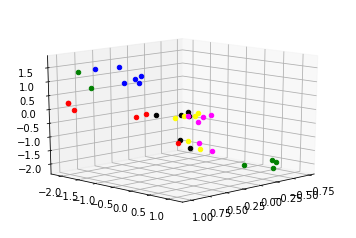

In [484]:
fig = plt.figure()

ax = fig.gca(projection='3d')
ax.view_init(elev=15., azim=45)
base = 0
for i,point in enumerate(x_test):
    
    ax.scatter3D(point[0],point[6] ,point[7], c=colors[y_test[i]])

In [28]:
# test for d20
examples,labels=read_data(test_x,stages = ["rest","_d20","_d10"],frames=["01.","02.","03."])
print(examples.shape)
x_test = np.reshape(examples,[-1,8])
y_test = np.reshape(labels,[-1])
y_test_one_hot = one_hot(y_test)
print(x_test.shape,y_test.shape,y_test_one_hot.shape)
print(y_test[:],y_test_one_hot[:],sep ='\n')

(36, 6, 8)
(216, 8) (216,) (216, 6)
['3ch' '4ch' '2ch' 'basal' 'mid' 'apical' '3ch' 'basal' 'apical' 'mid'
 '2ch' '4ch' 'mid' 'basal' '3ch' '2ch' '4ch' 'apical' '3ch' 'mid' 'apical'
 '4ch' 'basal' '2ch' 'apical' '4ch' 'mid' '3ch' 'basal' '2ch' '4ch'
 'apical' 'mid' '3ch' '2ch' 'basal' '2ch' '3ch' 'basal' 'apical' 'mid'
 '4ch' 'apical' 'basal' '2ch' 'mid' '4ch' '3ch' '2ch' 'apical' 'mid' '4ch'
 'basal' '3ch' 'apical' '2ch' 'mid' 'basal' '4ch' '3ch' 'mid' 'apical'
 '4ch' '3ch' '2ch' 'basal' '3ch' '2ch' '4ch' 'basal' 'mid' 'apical' '3ch'
 '2ch' '4ch' 'mid' 'apical' 'basal' 'basal' 'apical' '4ch' '2ch' 'mid'
 '3ch' '2ch' '4ch' 'apical' 'mid' '3ch' 'basal' 'mid' '3ch' '4ch' '2ch'
 'basal' 'apical' '4ch' '3ch' 'basal' 'mid' '2ch' 'apical' 'basal' '4ch'
 'mid' '3ch' '2ch' 'apical' 'mid' '3ch' '2ch' 'apical' '4ch' 'basal'
 'basal' '2ch' 'mid' '3ch' 'apical' '4ch' '3ch' 'apical' '2ch' 'basal'
 'mid' '4ch' 'apical' '4ch' '3ch' '2ch' 'mid' 'basal' 'mid' 'basal'
 'apical' '2ch' '4ch' '3ch' 'basal'

In [29]:
print(sess.run([accuracy,classes,correct_pred],{input_x:x_test,input_y:y_test_one_hot}))

[0.9305556, array([1, 2, 0, 4, 5, 3, 1, 4, 3, 5, 0, 2, 5, 4, 1, 0, 2, 3, 1, 3, 3, 2,
       3, 0, 3, 2, 3, 1, 3, 0, 2, 3, 3, 1, 0, 3, 0, 1, 4, 3, 5, 2, 3, 4,
       0, 5, 2, 1, 0, 3, 5, 2, 4, 1, 3, 0, 5, 4, 2, 1, 5, 3, 2, 1, 0, 4,
       1, 0, 2, 4, 5, 3, 1, 0, 2, 5, 3, 4, 4, 3, 2, 0, 5, 1, 0, 2, 3, 5,
       1, 4, 5, 1, 2, 0, 4, 3, 2, 1, 4, 5, 0, 3, 4, 2, 5, 1, 0, 3, 4, 1,
       0, 3, 2, 4, 4, 0, 4, 1, 3, 2, 1, 3, 0, 4, 4, 2, 3, 2, 1, 0, 3, 5,
       3, 5, 3, 0, 2, 1, 5, 2, 0, 3, 1, 3, 5, 0, 3, 4, 2, 1, 5, 1, 2, 3,
       0, 4, 2, 1, 4, 3, 5, 0, 5, 2, 0, 4, 1, 3, 5, 3, 4, 0, 2, 1, 4, 5,
       3, 0, 1, 2, 1, 4, 0, 5, 2, 3, 5, 1, 3, 2, 4, 0, 0, 1, 3, 4, 2, 5,
       1, 3, 5, 4, 0, 2, 4, 1, 0, 3, 5, 2, 4, 3, 5, 1, 2, 0]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  T

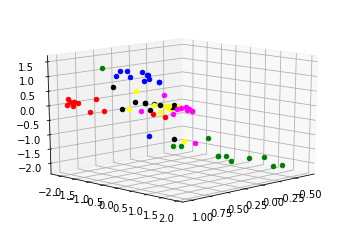

In [487]:
fig = plt.figure()

ax = fig.gca(projection='3d')
ax.view_init(elev=15., azim=45)
base = 0
for i,point in enumerate(x_test):
    
    ax.scatter3D(point[0],point[6] ,point[7], c=colors[y_test[i]])

In [28]:

sess = tf.Session(graph=tf.get_default_graph())
ckpt_path = '/home/minaessam/Documents/dicom_test/model _8_units/3 layers'
saver = tf.train.import_meta_graph(os.path.join(ckpt_path,'model8units3.meta'))
saver.restore(save_path=os.path.join(ckpt_path,'model8units3'),sess=sess)
 

INFO:tensorflow:Restoring parameters from /home/minaessam/Documents/dicom_test/model _8_units/3 layers/model8units3


In [29]:
print(sess.run([accuracy,classes,correct_pred],{input_x:x_test,input_y:y_test_one_hot}))

FailedPreconditionError: Attempting to use uninitialized value hidden1/bias
	 [[Node: hidden1/bias/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](hidden1/bias)]]

Caused by op 'hidden1/bias/read', defined at:
  File "/home/minaessam/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/minaessam/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-6d6b2a275c0f>", line 11, in <module>
    hidden1 = tf.layers.dense(inputs=input_x,units=units,activation=tf.nn.sigmoid,name='hidden1'                          ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 189, in dense
    return layer.apply(inputs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 805, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 362, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 728, in __call__
    self.build(input_shapes)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 926, in build
    trainable=True)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 276, in add_weight
    getter=vs.get_variable)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 565, in add_weight
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 535, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1467, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1217, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 527, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 481, in _true_getter
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 903, in _get_single_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2406, in default_variable_creator
    constraint=constraint)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 80, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3264, in identity
    "Identity", input=input, name=name)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value hidden1/bias
	 [[Node: hidden1/bias/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](hidden1/bias)]]


In [24]:
sess = tf.Session()

ckpt_path = '/home/minaessam/Documents/dicom_test/model _8_units'
saver = tf.train.import_meta_graph(os.path.join(ckpt_path,'model8units.meta'))
saver.restore(save_path=os.path.join(ckpt_path,'model8units'),sess=sess)

INFO:tensorflow:Restoring parameters from /home/minaessam/Documents/dicom_test/model _8_units/model8units


In [25]:
print(sess.run([accuracy,classes,correct_pred],{input_x:x_test,input_y:y_test_one_hot}))

FailedPreconditionError: Attempting to use uninitialized value hidden2/kernel
	 [[Node: hidden2/kernel/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](hidden2/kernel)]]

Caused by op 'hidden2/kernel/read', defined at:
  File "/home/minaessam/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/minaessam/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/minaessam/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-6d6b2a275c0f>", line 12, in <module>
    hidden2 = tf.layers.dense(inputs=hidden1,units=units,activation=tf.nn.sigmoid,name='hidden2'                          ,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=seed))
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 189, in dense
    return layer.apply(inputs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 805, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 362, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 728, in __call__
    self.build(input_shapes)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 917, in build
    trainable=True)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 276, in add_weight
    getter=vs.get_variable)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 565, in add_weight
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 535, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1467, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1217, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 527, in get_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 481, in _true_getter
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 903, in _get_single_variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2406, in default_variable_creator
    constraint=constraint)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 422, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 80, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3264, in identity
    "Identity", input=input, name=name)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/minaessam/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value hidden2/kernel
	 [[Node: hidden2/kernel/read = Identity[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/device:CPU:0"](hidden2/kernel)]]
